In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import seaborn as sns
from scipy import stats
import utils
import constants
import scipy.stats as stats

In [2]:
# Define the list of swarm IDs and trial IDs
swarm_ids = [1, 2, 3, 4, 5, 6, 7, 8]
trial_ids = [1, 2, 3]

# Initialize an empty list to store dataframes
dfs = []

# Loop over swarm IDs and trial IDs
for swarm_id in swarm_ids:
    for trial_id in trial_ids:
        trajectory_file = os.path.join("swarm_data", f"Swarm_{swarm_id}", f"Swarm{swarm_id}_Trial{trial_id}", f"Swarm{swarm_id}_Trial{trial_id}_correct_order.csv")

        if os.path.exists(trajectory_file):
            df = pd.read_csv(trajectory_file)
            df['swarm_id'] = swarm_id
            df['trial_id'] = trial_id
            df.rename(columns={'track': 'bot_id'}, inplace=True)
            df['speed'] = np.sqrt((df.groupby('bot_id')['x'].diff() ** 2) + (df.groupby('bot_id')['y'].diff() ** 2))
            df['accel'] = np.abs(np.append(np.diff(np.sqrt((df.groupby('bot_id')['x'].diff() ** 2) + (df.groupby('bot_id')['y'].diff() ** 2))), np.array(np.nan)))
            
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.drop(columns=['ignore', 'track_fixed'], inplace=True)

frames = np.arange(1, 129)  # Assuming frames are from 1 to 129
bot_ids = range(1, 5)       # Assuming bot_ids are from 1 to 4

# Create a MultiIndex from product of frames and bot_ids
index = pd.MultiIndex.from_product([frames, bot_ids], names=['frame', 'bot_id'])

# Reindex the dataframe to include all possible frames and bot_ids
complete_dfs = []

for swarm_id in swarm_ids:
    for trial_id in trial_ids:

        sub_df = df[(df['swarm_id'] == swarm_id) & (df['trial_id'] == trial_id)]
        sub_df = sub_df.set_index(['frame', 'bot_id']).reindex(index, fill_value=np.nan).reset_index()
        sub_df['swarm_id'] = swarm_id
        sub_df['trial_id'] = trial_id
        complete_dfs.append(sub_df)

df = pd.concat(complete_dfs, ignore_index=True)

# df['in_collision'] = df.apply(lambda row: utils.is_collision(row, df, threshold=10.0), axis=1)


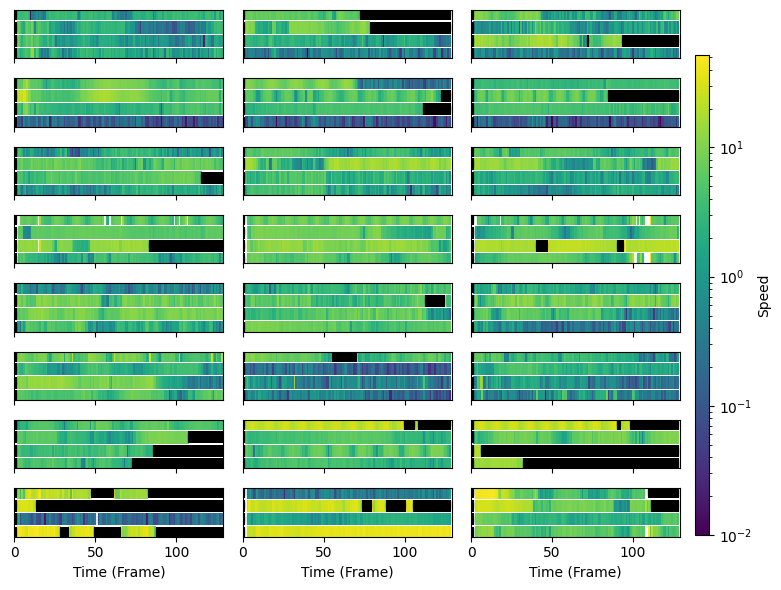

In [3]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(7, 6), sharex=True, sharey=True)

# Plot the speeds for each swarm and trial
for i, swarm in enumerate(swarm_ids):
    for j, trial in enumerate(trial_ids):
        for bot_id in range(1, 5):
            filtered_data = df[(df['swarm_id'] == swarm) & (df['trial_id'] == trial) & (df['bot_id'] == bot_id)]
        
            valid_data = filtered_data.dropna(subset=['speed'])
            nan_data = filtered_data[filtered_data['speed'].isna()]
            time = valid_data['frame'].values

            for y in [0, 0.1, 0.2, 0.3]:
                axs[i, j].scatter(time, np.zeros_like(time) + bot_id +y, c=valid_data['speed'], cmap='viridis', marker='|', label=f'Bot {bot_id}', vmin=0.01, vmax=52, norm='log')
            for y in [0, 0.1, 0.2, 0.3]:
                axs[i,j].scatter(nan_data['frame'], np.zeros_like(nan_data['frame']) + bot_id +y, color='black', marker='|')
        axs[7, j].set_xlabel('Time (Frame)')
        
    axs[i,j].set_xlim([0, 129])
        
# Add a color bar to the last axis
for ax in axs.flatten():
    ax.yaxis.set_visible(False)

# Adjust layout
plt.tight_layout()
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', label='Speed')
plt.show()

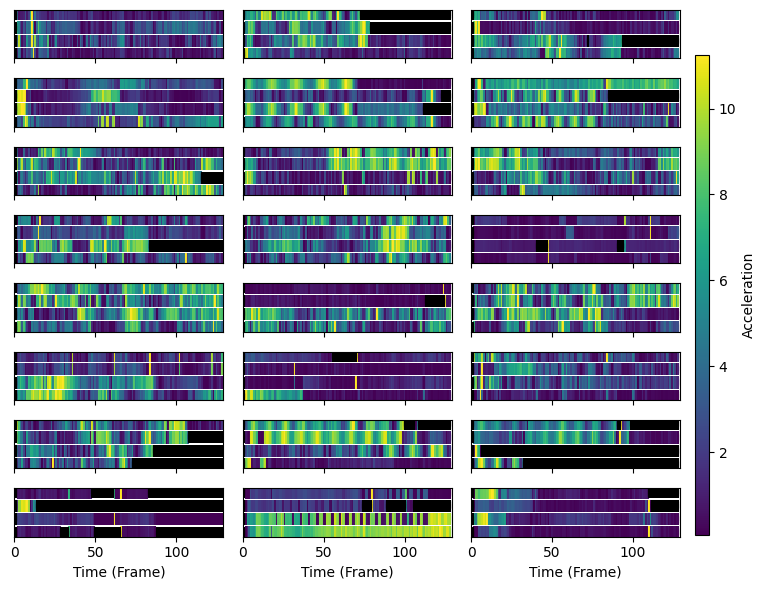

In [4]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(7, 6), sharex=True, sharey=True)

# Plot the speeds for each swarm and trial
for i, swarm in enumerate(swarm_ids):
    for j, trial in enumerate(trial_ids):
        for bot_id in range(1, 5):
            filtered_data = df[(df['swarm_id'] == swarm) & (df['trial_id'] == trial) & (df['bot_id'] == bot_id)]
        
            valid_data = filtered_data.dropna(subset=['accel'])
            nan_data = filtered_data[filtered_data['accel'].isna()]
            time = valid_data['frame'].values

            for y in [0, 0.1, 0.2, 0.3]:
                axs[i, j].scatter(time, np.zeros_like(time) + bot_id +y, c=valid_data['accel'], cmap='viridis', marker='|', label=f'Bot {bot_id}')
            for y in [0, 0.1, 0.2, 0.3]:
                axs[i,j].scatter(nan_data['frame'], np.zeros_like(nan_data['frame']) + bot_id +y, color='black', marker='|')
        axs[7, j].set_xlabel('Time (Frame)')
        
    axs[i,j].set_xlim([0, 129])
        
# Add a color bar to the last axis
for ax in axs.flatten():
    ax.yaxis.set_visible(False)

# Adjust layout
plt.tight_layout()
cbar_ax = fig.add_axes([1.0, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(axs[0, 0].collections[0], cax=cbar_ax, orientation='vertical', label='Acceleration')
plt.show()

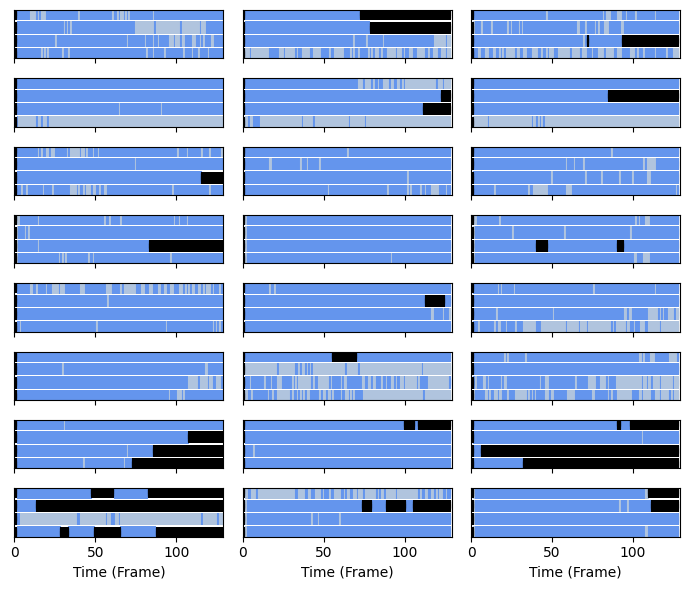

In [5]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(7, 6), sharex=True, sharey=True)
threshold = 0.5
# Plot the speeds for each swarm and trial
for i, swarm in enumerate(swarm_ids):
    for j, trial in enumerate(trial_ids):
        for bot_id in range(1, 5):
            filtered_data = df[(df['swarm_id'] == swarm) & (df['trial_id'] == trial) & (df['bot_id'] == bot_id)]
        
            valid_data = filtered_data.dropna(subset=['speed'])
            nan_data = filtered_data[filtered_data['speed'].isna()]
            time = valid_data['frame'].values
            colors = np.where(valid_data['speed'] > threshold, 'cornflowerblue', 'lightsteelblue')
            for y in [0, 0.1, 0.2, 0.3]:
                axs[i, j].scatter(time, np.zeros_like(time) + bot_id +y, c=colors, marker='|', label=f'Bot {bot_id}')
            for y in [0, 0.1, 0.2, 0.3]:
                axs[i,j].scatter(nan_data['frame'], np.zeros_like(nan_data['frame']) + bot_id +y, color='black', marker='|')
        axs[7, j].set_xlabel('Time (Frame)')
            
    axs[i,j].set_xlim([0, 129])
        
# Add a color bar to the last axis
for ax in axs.flatten():
    ax.yaxis.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()